In [10]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from collections import Counter
import os
import time
import joblib


In [12]:
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

# XGBoost
from xgboost import XGBClassifier

In [14]:
np.random.seed(42)



In [15]:
pd.set_option('display.max_colwidth', 200)
plt.style.use('ggplot')
%matplotlib inline

In [16]:
columns = ['sentiment', 'id', 'date', 'query', 'user', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', 
                 encoding='ISO-8859-1', 
                 header=None, 
                 names=columns)

# Dataset info
print("\n" + "="*80)
print("Dataset Shape:", df.shape)
print("="*80 + "\n")

# Display first samples
print("First 5 samples:")
display(df.head())

# Dataset information
print("\nDataset Information:")
df.info()

# Convert sentiment to binary (0, 1)
df['sentiment'] = df['sentiment'].replace(4, 1)  # 0=negative, 1=positive

# Sentiment distribution
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())


Dataset Shape: (1600000, 6)

First 5 samples:


,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB

Sentiment Distribution:
sentiment
0    800000
1    800000
Name: count, dtype: int64


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11916\2120054095.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=data, palette='viridis')


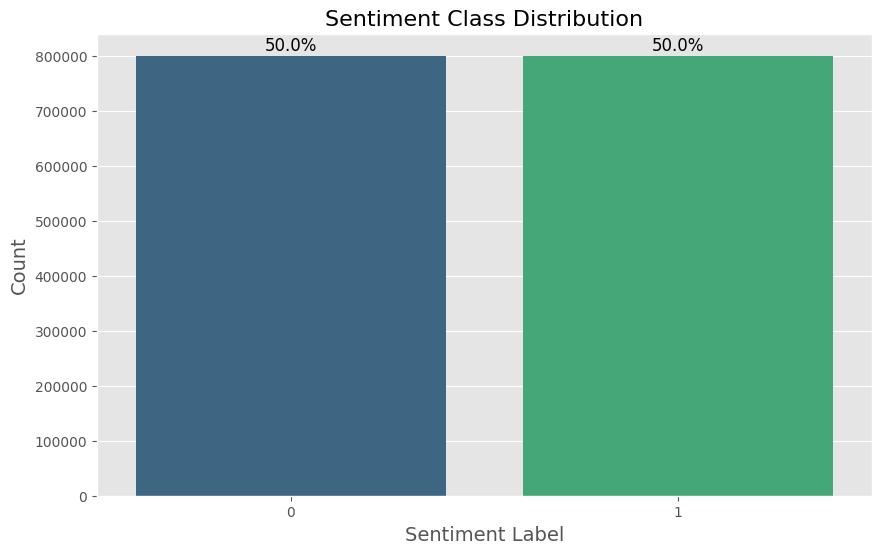

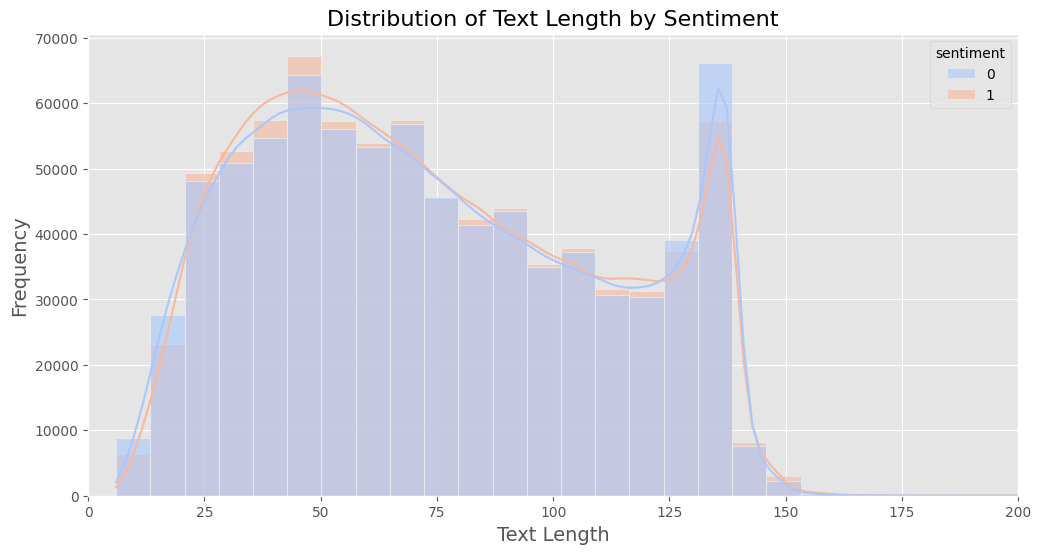

In [17]:
def plot_sentiment_distribution(data):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='sentiment', data=data, palette='viridis')
    plt.title('Sentiment Class Distribution', fontsize=16)
    plt.xlabel('Sentiment Label', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    
    # Add percentages
    total = len(data)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width()/2., height + 10000,
                f'{height/total:.1%}', ha='center', fontsize=12)
    plt.show()

plot_sentiment_distribution(df)


df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='sentiment', bins=50, 
             palette='coolwarm', alpha=0.6, kde=True)
plt.title('Distribution of Text Length by Sentiment', fontsize=16)
plt.xlabel('Text Length', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0, 200)
plt.show()


In [18]:
print("\nText Length Statistics:")
print(df.groupby('sentiment')['text_length'].describe())


Text Length Statistics:
              count       mean        std  min   25%   50%    75%    max
sentiment                                                               
0          800000.0  74.301790  36.743260  6.0  44.0  70.0  104.0  359.0
1          800000.0  73.878433  36.135274  6.0  44.0  69.0  103.0  374.0


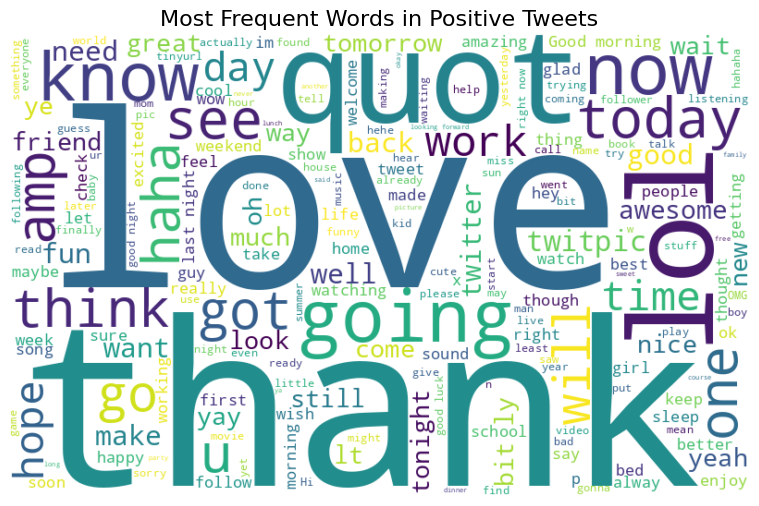

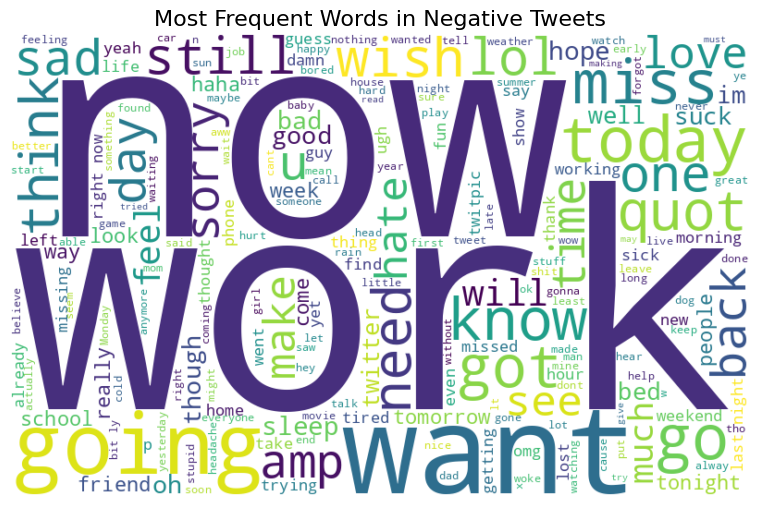

In [19]:
def generate_wordcloud(data, sentiment, title):
    text = ' '.join(data[data['sentiment'] == sentiment]['text'])
    wordcloud = WordCloud(width=800, height=500, 
                          background_color='white', 
                          max_words=200, 
                          colormap='viridis').generate(text)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

# Positive sentiment word cloud
generate_wordcloud(df, 1, 'Most Frequent Words in Positive Tweets')

# Negative sentiment word cloud
generate_wordcloud(df, 0, 'Most Frequent Words in Negative Tweets')


C:\Users\Administrator\AppData\Local\Temp\ipykernel_11916\2897461595.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[val[1] for val in words_freq],


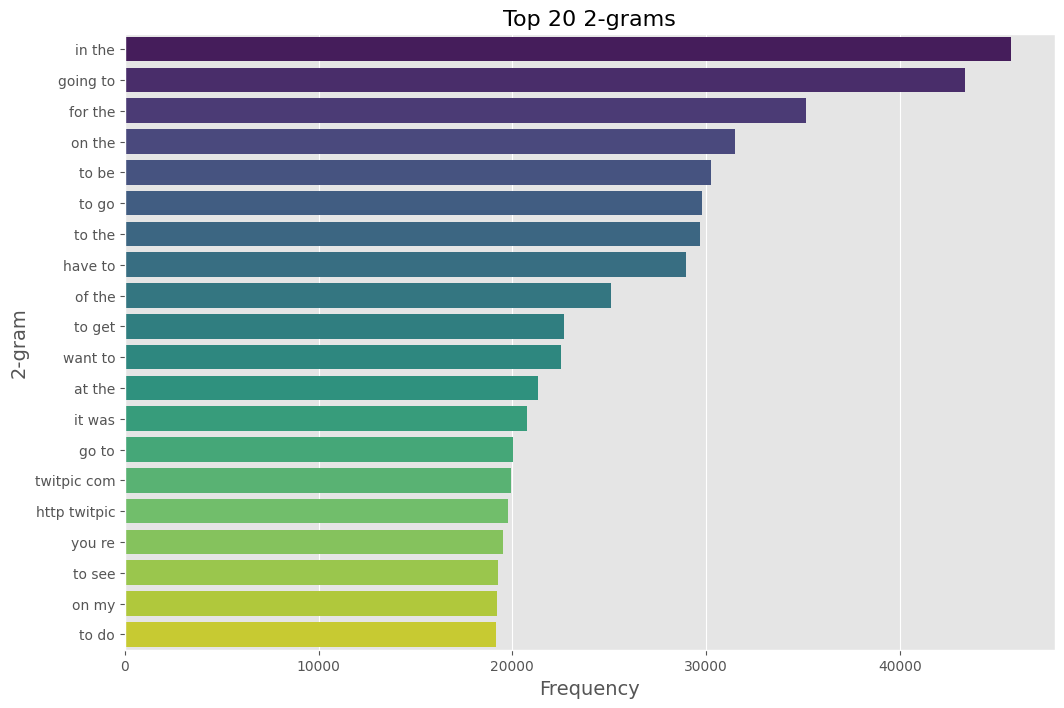

KeyboardInterrupt: 

In [20]:
def plot_top_ngrams(data, n=2, top=20):
    vec = CountVectorizer(ngram_range=(n, n), max_features=2000).fit(data['text'])
    bag_of_words = vec.transform(data['text'])
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top]
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=[val[1] for val in words_freq], 
                y=[val[0] for val in words_freq], 
                palette='viridis')
    plt.title(f'Top {top} {n}-grams', fontsize=16)
    plt.xlabel('Frequency', fontsize=14)
    plt.ylabel(f'{n}-gram', fontsize=14)
    plt.savefig(f'top_{n}grams.png', bbox_inches='tight')
    plt.show()

# Top bigrams
plot_top_ngrams(df, n=2, top=20)

# Top trigrams
plot_top_ngrams(df, n=3, top=20)

In [ ]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\\w+|#\\w+', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\\d+', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and stem
    stop_words = set(stopwords.words('english'))
    ps = PorterStemmer()
    tokens = [ps.stem(word) for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)


In [ ]:
sample_size = 200000  # Reduce for faster prototyping
df_sample = df.sample(sample_size, random_state=42).copy()

print("Cleaning text...")
start_time = time.time()
df_sample['cleaned_text'] = df_sample['text'].apply(clean_text)
print(f"Text cleaning completed in {time.time() - start_time:.2f} seconds")

# Display cleaned text
print("\nOriginal vs Cleaned Text:")
display(df_sample[['text', 'cleaned_text']].head(10))

NameError: name 'df' is not defined

In [ ]:
X = df_sample['cleaned_text']
y = df_sample['sentiment']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 160000
Test set size: 40000


In [ ]:
print("Vectorizing text with TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("TF-IDF matrix shape:", X_train_tfidf.shape)



Vectorizing text with TF-IDF...
TF-IDF matrix shape: (160000, 5000)
TF-IDF matrix shape: (160000, 5000)


In [ ]:
def train_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    print(f"\n{'='*50}")
    print(f"Training {model_name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f"Training completed in {train_time:.2f} seconds")
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    print(f"\nAccuracy: {accuracy:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.savefig(f'confusion_matrix_{model_name}.png', bbox_inches='tight')
    plt.show()
    
    return model, accuracy, roc_auc


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss')
}


Training Logistic Regression...
Training completed in 1.84 seconds

Accuracy: 0.7712
ROC AUC: 0.8529

Confusion Matrix:
[[14969  5002]
 [ 4150 15879]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77     19971
           1       0.76      0.79      0.78     20029

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000

Training completed in 1.84 seconds

Accuracy: 0.7712
ROC AUC: 0.8529

Confusion Matrix:
[[14969  5002]
 [ 4150 15879]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.75      0.77     19971
           1       0.76      0.79      0.78     20029

    accuracy                           0.77     40000
   macro avg       0.77      0.77      0.77     40000
weighted avg       0.77      0.77      0.77     40000



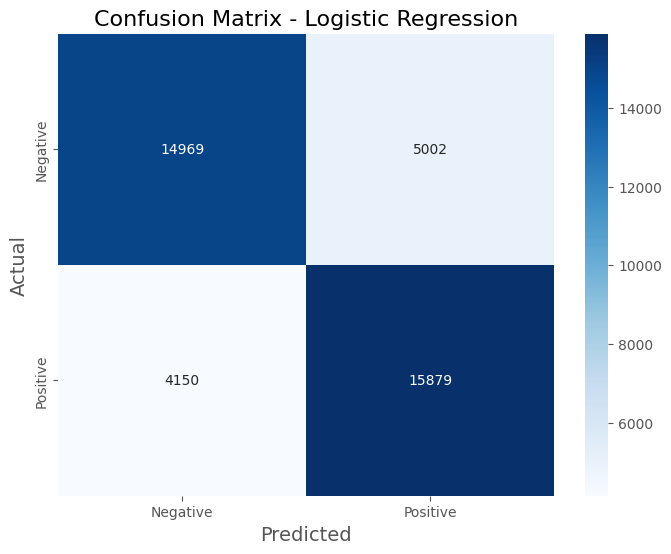

Model saved to models/Logistic_Regression.pkl

Training Random Forest...
Training completed in 346.86 seconds
Training completed in 346.86 seconds

Accuracy: 0.7572
ROC AUC: 0.8332

Confusion Matrix:
[[15116  4855]
 [ 4858 15171]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     19971
           1       0.76      0.76      0.76     20029

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000


Accuracy: 0.7572
ROC AUC: 0.8332

Confusion Matrix:
[[15116  4855]
 [ 4858 15171]]

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     19971
           1       0.76      0.76      0.76     20029

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76     

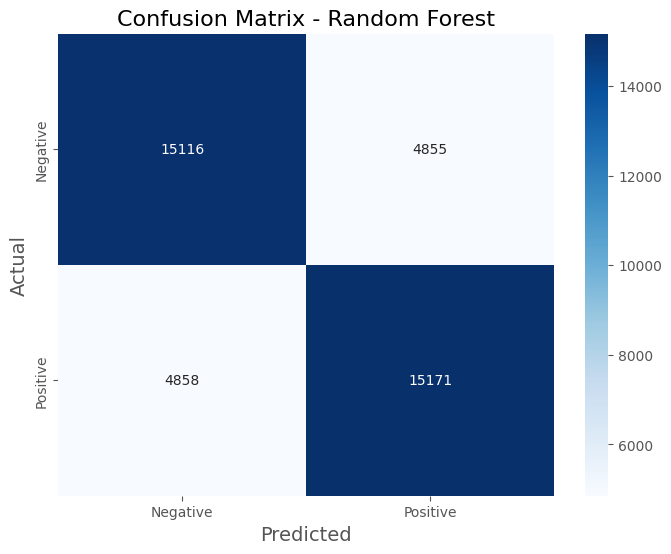

Model saved to models/Random_Forest.pkl

Training XGBoost...


c:\Users\Administrator\.conda\envs\torchandcuda\lib\site-packages\xgboost\core.py:158: UserWarning: [21:35:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training completed in 38.63 seconds

Accuracy: 0.7457
ROC AUC: 0.8223

Confusion Matrix:
[[13289  6682]
 [ 3492 16537]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.67      0.72     19971
           1       0.71      0.83      0.76     20029

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.74     40000
weighted avg       0.75      0.75      0.74     40000



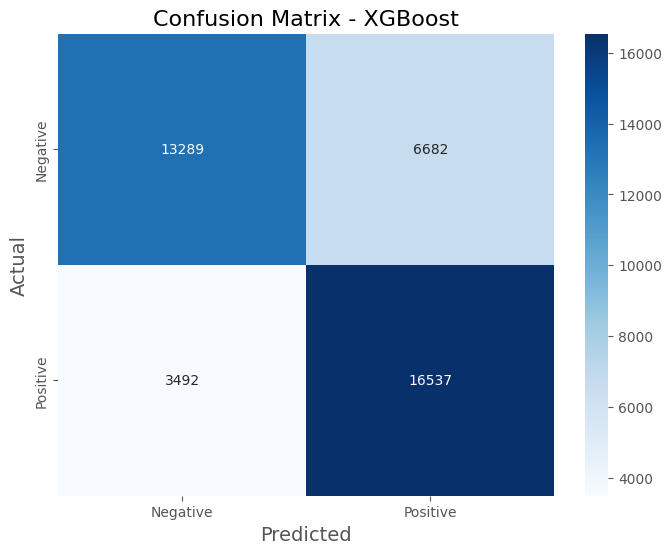

Model saved to models/XGBoost.pkl


In [ ]:
results = {}
for name, model in models.items():
    trained_model, accuracy, roc_auc = train_evaluate_model(
        model, X_train_tfidf, y_train, X_test_tfidf, y_test, name
    )
    results[name] = {
        'model': trained_model,
        'accuracy': accuracy,
        'roc_auc': roc_auc
    }
    
    # Save model
    model_path = f"models/{name.replace(' ', '_')}.pkl"
    joblib.dump(trained_model, model_path)
    print(f"Model saved to {model_path}")

In [ ]:
from tensorflow.keras.layers import SpatialDropout1D

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

print("Padded sequences shape:", X_train_pad.shape)

NameError: name 'Tokenizer' is not defined

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.metrics import accuracy_score, roc_auc_score

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU name: {torch.cuda.get_device_name(0)}")

# %%
# Prepare PyTorch datasets
def create_datasets(X_pad, y, batch_size=1024, test_size=0.2):
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X_pad, dtype=torch.long)
    y_tensor = torch.tensor(y.values, dtype=torch.float32)
    
    # Create TensorDataset
    dataset = TensorDataset(X_tensor, y_tensor)
    
    # Split into train and validation
    val_size = int(len(dataset) * test_size)
    train_size = len(dataset) - val_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_loader, val_loader

# Create data loaders
train_loader, val_loader = create_datasets(X_train_pad, y_train, batch_size=1024)
test_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_test_pad, dtype=torch.long),
        torch.tensor(y_test.values, dtype=torch.float32)
    ), 
    batch_size=1024
)

# %%
# Define LSTM model
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers,
                            bidirectional=True,
                            dropout=dropout,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x shape: [batch_size, seq_length]
        embedded = self.dropout(self.embedding(x))
        # embedded shape: [batch_size, seq_length, embedding_dim]
        
        output, (hidden, cell) = self.lstm(embedded)
        # output shape: [batch_size, seq_length, hidden_dim * 2]
        # hidden shape: [num_layers * 2, batch_size, hidden_dim]
        
        # Concatenate final hidden states from both directions
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        # hidden shape: [batch_size, hidden_dim * 2]
        
        return self.fc(hidden)

# Model parameters
VOCAB_SIZE = 10000
EMBEDDING_DIM = 256
HIDDEN_DIM = 128
OUTPUT_DIM = 1
N_LAYERS = 2
DROPOUT = 0.3

model = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).to(device)

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# %%
# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    
    for batch in loader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        predictions = model(inputs).squeeze(1)
        loss = criterion(predictions, labels)
        
        acc = binary_accuracy(predictions, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    
    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            predictions = model(inputs).squeeze(1)
            loss = criterion(predictions, labels)
            
            acc = binary_accuracy(predictions, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(loader), epoch_acc / len(loader)

# Accuracy helper
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    return correct.mean()

# %%
# Training loop with early stopping
N_EPOCHS = 15
best_val_loss = float('inf')
patience_counter = 0
patience = 3

train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("Training LSTM model...")
for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    
    end_time = time.time()
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {val_loss:.3f} |  Val. Acc: {val_acc*100:.2f}%')
    print(f'\t Epoch Time: {end_time - start_time:.2f}s')
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'saved_models/best_lstm_model.pt')
        print("\tSaved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping after {epoch+1} epochs")
            break

# Load best model
model.load_state_dict(torch.load('saved_models/best_lstm_model.pt'))
print("Loaded best model for evaluation")

# %%
# Evaluate on test set
def evaluate_test(model, loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in loader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            
            predictions = model(inputs).squeeze(1)
            probs = torch.sigmoid(predictions).cpu().numpy()
            preds = torch.round(torch.sigmoid(predictions)).cpu().numpy()
            
            all_preds.extend(preds)
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds, all_probs

# Test evaluation
test_labels, test_preds, test_probs = evaluate_test(model, test_loader)

# Metrics
test_acc = accuracy_score(test_labels, test_preds)
test_roc_auc = roc_auc_score(test_labels, test_probs)
conf_matrix = confusion_matrix(test_labels, test_preds)
class_report = classification_report(test_labels, test_preds)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - LSTM (PyTorch)', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.savefig('confusion_matrix_lstm_pytorch.png', bbox_inches='tight')
plt.show()

# Save final model
torch.save(model.state_dict(), 'saved_models/final_lstm_model.pt')
print("LSTM model saved to saved_models/final_lstm_model.pt")

# Add results to comparison
results['LSTM (PyTorch)'] = {
    'accuracy': test_acc,
    'roc_auc': test_roc_auc
}

Using device: cuda
GPU name: NVIDIA GeForce RTX 2050


NameError: name 'X_train_pad' is not defined